# Investigating the Relationships Between Macroeconomic Variables

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This analysis will explore standard macroeconomic relationships. This analysis will focus on 5 key metrics: central bank interest rate, investment inflow, investment outflow,  investment, and inflation. All are represented as percentages. Investment inflow, outflow, overall investment, and inflation are percentages of total gdp. Discount rates are central bank interest rates and are measured as a percentage of money owed on a loan. The focus will be on the top tenth percentile of high gdp countries.

First each variable will be explored. The focus will be on describing the distribution and on removing outliers. Outliers will heavily skew the analysis of our relationships, and are usually based on rare economic conditions. Although those points are useful to zoom in on to see extreme cases, here it is more useful to see typical rates.

Next the relationships between macroeconomic variables will be explored. Central banks interest rates will be the explanatory variable and all other variables will be analyzed one at a time as response variables. This will allow the reader to tie all macroeconomic conditions to central bank rates, which is typically a major indicator for macroeconomic activity on a national level. The reader will also be able to tie interest rates to foreign economic activity through the analysis of inflow and outflow as response variables to central bank interest rates.

Note here the limitations of this analysis. 

At this point in time all analysis is descriptive in nature. Rigorous hypothesis testing should be used to lower the probability that these relationships are due to chance before generalizing these relationships.

Also all relationships are correlations and are only describing the data. Causation should not be implied from this investigation. In other words, central bank interest rates may not be causing the relationship to any of the metrics under investigation.

Other then addressing the limitations to this analysis, it can be investigated further in a few ways:

Data modeling can be used to formalize the relationships between macroeconomic variables and bring rigor to predictictions. 

Examining the relationships across percentiles to see if the relationships differ or if they hold statistical rigor to the top 10th percentile could also add predictive power to this analysis. 

New metrics could also be gathered and analyzed as response variables. If countries are used as the primary key a left join can be performed, adding more data to countries of interest. 

Lastly, yearly data is available but not used in this analysis. Therefore time series analysis can be performed to see how central bank interest rates or other metrics have varied over time.

## Libraries Used

The python data analytics ecosystem is used during this analysis. Numpy and pandas are used for wrangling the datasets into the proper format and for analytical computations. Matplotlib and seaborn are used for data visualization.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## Data Gathered

Data was gathered from `gapminder.org`, a non for profit that creates tools for journalists and students to better understand the world through data. They publicly supply datasets of various economic metrics across years and countries.

Six datasets were gathered for this analysis. 

The first dataset measures gross domesitc product. GDP measures the total value of goods produced and services provided in a country during a single year. It is quantified by taking the quantities of all goods and services produced in a year, multiplying them by their prices, and summing the total. The unit of measurment then is the currency of the country. Using purchasing power parity rates (ppp) standardizes gdp to international dollars by computing foreign currencies in terms of united states dollars. This allows for across country comparissons of gdp. 

This dataset is used to group countries by percentiles for analysis. The top 10th percentile of rich gdp countries is the focus here.

The other five datasets are metrics of interest for those countries filtered by percentile. That includes central bank interest rates (discount rates), investment inflow, investment outflow, overall investment, and inflation.

Central bank interest rates, also known as the discount rate, is the percentage of money owed on a loan borrowed by banks from the central bank. This rate is used by central banks to shape monetary policy. Investment inflow/ outflow measure the investment flowing in and out of the economy as a percentage of total gdp. These two metrics paint a picture of foreign economic activity related to the country of interest. Investment overall is the total amount of investment in each country. Inflation is the percentage of price level increase over a year period.

Below are the paths and labels of the local datasets used for analysis.

In [3]:
# GDP for filtering by percentile
gdp_path = "total_gdp_ppp_inflation_adjusted.csv"
# Metrics for generating the master dataset
discount = "central_bank_discount_rate_annual_percent.csv", "discount"
inflows = "foreign_direct_investment_net_inflows_percent_of_gdp.csv", "inflow"
outflows = "foreign_direct_investment_net_outflows_percent_of_gdp.csv", "outflow"
inflation = "inflation_annual_percent.csv", "inflation"
investment = "investments_percent_of_gdp.csv", "investment"
paths_and_labels = [discount, inflows, outflows, inflation, investment]

<a id='wrangling'></a>
## Data Wrangling


To create the master dataset, the top 10th percentile of countries were used as a filter on the metrics of interest. Then all the years and the metrics associated with that year were gathered for each relevant country.

The final dataset has the columns:

- year

- discount

- inflow

- outflow

- inflation

- investment

- country

The dataset is created using a series of functions listed below. It is the belief of the writer that reading how this dataframe was created is useful in understanding the raw sources of data, which will help the reader understand the analysis later.

Unit testing also exists below each function for the purposes of documentation by displaying the input output format and to assure the functions work correctly.

Below in the `derive_top_countries` function, roughly 200 countries, roughly across the last 200 years, report gdp data. Lots of null values exist in the original data source. Null values lead to a bias towards countries that have reported data being classified as richer than countries that have lots of missing data. Therefore the percentiles are best guesses and may not hold up to rigor. Having said that they are good enough for the purposes of this analysis.

The gdp's across years are aggregated by sum grouped by country. Then the countries are sorted. The function `derive_country_by_percentiles` then  returns the sorted values between two percentiles.

The function `clean_countries` is a utility function that makes the country labels follow a lowercase, alphanumeric, and snakecase format.

The output of the main function, `derive_country_by_percentile` outputs a list of countries that are used to filter the metrics by gdp percentiles.

In [4]:
# Cleans country strings to be alphanumeric, lowercase, and snakecase
def clean_countries(df):
    df['country'] = df['country'].replace(regex=r'[^A-Za-z0-9 ]', value='').replace(regex=' ',value='_').str.lower()
    return df

In [5]:
import sys
def derive_top_countries(gdp_path=gdp_path, number_of_countries=sys.maxsize):
    gdp_df = pd.read_csv(gdp_path)
    gdp_df = clean_countries(gdp_df)
    gdp_df = gdp_df.transpose()
    gdp_df.columns = gdp_df.loc["country"]
    gdp_df = gdp_df.drop("country", axis=0)
    richest_countries = gdp_df.sum().sort_values(ascending=False)
    top_countries = list(richest_countries[0:number_of_countries].index)
    return top_countries

assert derive_top_countries(gdp_path, 10) == ['united_states', 'china', 'japan', 'germany',
                                               'russia', 'india', 'france','united_kingdom',
                                                'italy','brazil']

In [6]:
def derive_countries_by_percentile(percentile_1, percentile_2):
    fix_perc = lambda x: 100 - x
    all_countries = np.array(derive_top_countries())
    indexes = np.array([i for i, val in enumerate(all_countries)])
    x = int(round(np.percentile(indexes, fix_perc(percentile_2)), 0))
    y = int(round(np.percentile(indexes, fix_perc(percentile_1)), 0))
    return all_countries[x:y+1]

assert list(derive_countries_by_percentile(0, 100)) == derive_top_countries()

In the function `create_dataset`, the metrics are merged together into the final dataframe. The specifics of how the dataset is created is listed as comments throughout the function.

The `create_query_string` function is a utility function that builds the string to query the pandas dataframe. It takes in the country list, typically given by `derive_countries_by_percentile`, as input to form the query string. It is used in the `create_dataset` function.

In [7]:
# Creates a query string for our metric datasets used in create_dataset
def create_query_string(country_list):
    country_list = [country_list] if isinstance(country_list, str) else country_list
    create_country = lambda x: "country == '{}'".format(x)
    new_country_list = [create_country(country) for country in country_list]
    return ' or '.join(new_country_list)

country_list = ["Germany"]
query_1 = create_query_string(country_list)
country_list = ["Germany", "United States"]
query_2 = create_query_string(country_list)
country_list = "United States"
query_3 = create_query_string(country_list)
assert query_1 == "country == 'Germany'"
assert query_2 == "country == 'Germany' or country == 'United States'"
assert query_3 == "country == 'United States'"

In [8]:
# Creates the metric dataset, the main datasets used for our analysis
from functools import reduce
def create_dataset(paths_and_labels, countries_list, drop_null_rows=True):
    countries_df_list = []
    for country in countries_list:
        df_list = []
        for path, metric_label in paths_and_labels:
            # Read in the dataset for the metric of interest
            raw_df = pd.read_csv(path)
            raw_df = clean_countries(raw_df)
            # Filter the data by the countries of interest
            query = create_query_string(country)
            raw_df.query(query, inplace=True)
            # Transpose matrix so we can 
            transposed_df = raw_df.T
            # Temperarily remove the country while wrangling
            transposed_df.drop("country", inplace=True)
            # Create a year column and reset index
            transposed_df.reset_index(inplace=True)
            # rename only column name of metric or the year
            rename_cols_func = lambda x: "year" if x == "index" else metric_label
            transposed_df.rename(columns=rename_cols_func, inplace=True)
            # Place all the dataframes in a list to be joined
            df_list.append(transposed_df)
        # Merge countries df
        merge_df_func = lambda x, y: pd.merge(x, y, on = 'year', how="outer")
        country_df = reduce(merge_df_func, df_list)
        # Create country label
        country_df["country"] = country
        if drop_null_rows:
            country_df.dropna(inplace=True)
        countries_df_list.append(country_df)
    # Create countries dataframe
    countries_df = pd.concat(countries_df_list, sort=False)
    if drop_null_rows:
        countries_df.dropna(inplace=True)
    countries_df = countries_df.reset_index(drop=True)
    # Modify datatypes
    countries_df["year"] = countries_df["year"].astype(int, errors="ignore")
    countries_df["discount"] = countries_df["discount"].astype(float, errors="ignore")
    countries_df["inflow"] = countries_df["inflow"].astype(float, errors="ignore")
    countries_df["outflow"] = countries_df["outflow"].astype(float, errors="ignore")
    countries_df["inflation"] = countries_df["inflation"].astype(float, errors="ignore")
    countries_df["investment"] = countries_df["investment"].astype(float, errors="ignore")
    # Normalize percentages for discount, inflation, and investment
    countries_df["inflation"] = countries_df["inflation"] / 100
    countries_df["investment"] = countries_df["investment"] / 100
    countries_df["discount"] = countries_df["discount"] / 100
    return countries_df
    
# Test dataset generation by single values
test_dataset = create_dataset(paths_and_labels, ["united_states"])
assert test_dataset.shape == (37, 7)
assert test_dataset.isna().any().any() == False
test_dataset = create_dataset(paths_and_labels, ["germany"])
assert test_dataset.shape == (28, 7)
assert test_dataset.isna().any().any() == False
test_dataset = create_dataset(paths_and_labels, ["united_states", "germany"])
assert test_dataset.shape == (65, 7)
assert test_dataset.isna().any().any() == False

# Test dataset generation by gdp percentiles
country_list = derive_countries_by_percentile(80, 90)
test_dataset = create_dataset(paths_and_labels, country_list)
assert test_dataset.shape == (449, 7)
assert test_dataset.isna().any().any() == False

# Test dataset to see if not dropping rows works
country_list = derive_countries_by_percentile(80, 100)
test_dataset = create_dataset(paths_and_labels, country_list, drop_null_rows=False)
assert test_dataset.shape == (2800, 7)

# Large test datasets (all countries) commented out for faster execution

# ## Test largest dataset possible with dropping rows ##
# country_list = derive_countries_by_percentile(0, 100)
# big_test_dataset = create_dataset(paths_and_labels, country_list)
# assert big_test_dataset.shape == (2239, 7)
# assert big_test_dataset.isna().all().all() == False

# ## Test largest dataset possible without dropping rows  ##
# country_list = derive_countries_by_percentile(0, 100)
# big_test_dataset = create_dataset(paths_and_labels, country_list, drop_null_rows=False)
# assert big_test_dataset.shape == (13580, 7)

<a id='eda'></a>
## Exploratory Data Analysis

Recall in the introduction the focus of the analysis:

```
First each variable will be explored. The focus will be on describing the distribution and on removing outliers. Outliers will heavily skew the analysis of our relationships, and are usually based on rare economic conditions. Although those points are useful to zoom in to see extreme cases, here it is more useful to see typical rates.

Next the relationships between macroeconomic variables will be explored. Central banks interest rates will be the explanatory variable and all other variables will be analyzed one at a time as response variables. This will allow the reader to tie all macroeconomic conditions to central bank rates, which is typically a major indicator for macroeconomic activity on a national level. The reader will also be able to tie interest rates to foreign economic activity through the analysis of inflow and outflow as response variables to central bank interest rates.

```

This analysis will begin by performing univariate analysis mostly through histograms and descriptive statistics. Outliers that have the potential to throw off the analysis will be taken care of.

The relationships will then be analyzed via correlation as a summary statistic and scatterplots. Theories of why the distribution of single variables and the relationships exists as they do will be generated but not rigorously tested. Rigorous testing is beyond the scope of this analysis.

In [9]:
country_list = derive_countries_by_percentile(90, 100)
top_gdp_df = create_dataset(paths_and_labels, country_list)
top_gdp_df_clean = top_gdp_df.copy()

### Distribution of the Central Bank Interest Rate

To begin we will look at descriptive statistics of the central bank interest rate and then we will attempt to describe why they are that way through analysis and visualization.

In [10]:
top_gdp_df_clean.discount.describe()

count    372.000000
mean       0.123817
std        0.147114
min        0.000000
25%        0.050000
50%        0.080000
75%        0.130000
max        1.600000
Name: discount, dtype: float64

Central bank discount rates tend to be between 5% and 13% with a median of 8%. Strangely, the standard deviation of 0.15 is larger then the interquartile range. The standard deviation is computed using the formula $$s = \sqrt{\frac{\sum(x_i - \mu)^2}{N}}$$

Because the dataset is highly right skewed (the mean is closer to the 75th percentile rather than to the 50th percentile) and the standard deviation is highly dependent on the mean for its computation, the standard deviation is not an accurate measure of spread for the dataset. This can be visualized in a histogram.

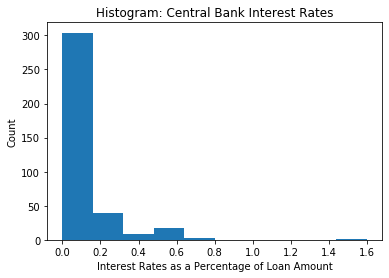

In [11]:
plt.hist(data=top_gdp_df_clean, x="discount");
plt.title("Histogram: Central Bank Interest Rates")
plt.xlabel("Interest Rates as a Percentage of Loan Amount")
plt.ylabel("Count");

The percentage of our dataset above each percentage point can be investigated, dropping outliers that are messing up the summary statistics, and keep the bulk of the data for better analysis.

In [12]:
derive_perc_func = lambda df, x: df.query("discount > @x").shape[0] / df.discount.shape[0]\

investigate_perc_above = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1]
for perc in investigate_perc_above:
    x = derive_perc_func(top_gdp_df_clean, perc)
    print("Percentage above {:.2f} is {:.4f}%".format(perc, x))

Percentage above 0.20 is 0.1317%
Percentage above 0.30 is 0.0780%
Percentage above 0.40 is 0.0672%
Percentage above 0.45 is 0.0565%
Percentage above 0.50 is 0.0376%
Percentage above 0.55 is 0.0188%
Percentage above 0.60 is 0.0081%
Percentage above 0.80 is 0.0027%
Percentage above 1.00 is 0.0027%


From the above analysis it can be seen that above 30% of discount rate is less then 8% of the data points. Perhaps if the top 70% of discount rates are eliminated (30 out of 372 data points) it will improve the descriptive statistics and therefore the entire analysis. Highly skewed data regarding the key metric, discount rates, is undesirable.

In [13]:
top_gdp_df_clean = top_gdp_df_clean.query("discount < 0.3")

In [14]:
top_gdp_df_clean.discount.describe()

count    342.000000
mean       0.087778
std        0.056928
min        0.000000
25%        0.050000
50%        0.070000
75%        0.120000
max        0.290000
Name: discount, dtype: float64

In [15]:
assert top_gdp_df_clean.shape[0] + 30 == top_gdp_df.shape[0]

Although this didn't completely fix the problem, it only eliminated 30 points and reduced our standard devation by about 300%. It also made the mean less then half a standard deviation from the median. It did this while only reducing the size of the dataset by about 8%. This is acceptable because this analysis will only involve univariate and bivariate analysis, so data loss for other metrics (say investment) won't affect the other analysis' (like inflation).

Below a PMF and CDF will be displayed side by side to describe the distribution of discount rates after the removal of the outliers

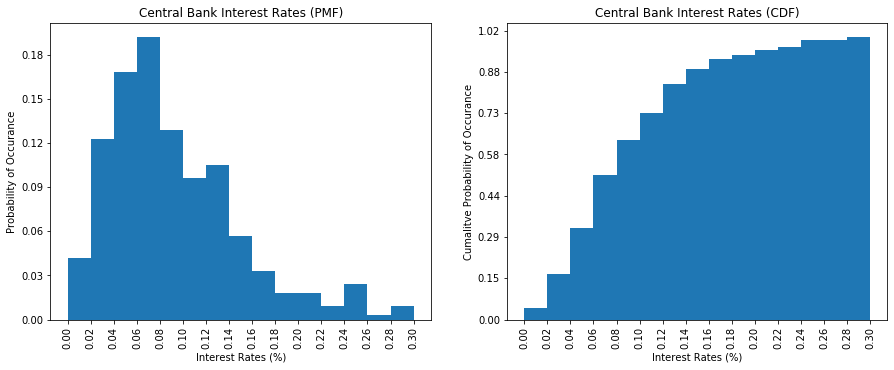

In [16]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
bins = np.arange(0, 0.3 + 0.02, 0.02)
labels = ["{:.2f}".format(b) for b in bins]
plt.hist(data=top_gdp_df_clean, x="discount", bins=bins);
y_ticks = [0, 10, 20, 30, 40, 50, 60]
n_rows = top_gdp_df_clean.discount.shape[0]
y_labels = ["{:.2f}".format(tick/n_rows) for tick in y_ticks]
plt.xticks(ticks=bins,labels=labels, rotation=90)
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.title("Central Bank Interest Rates (PMF)")
plt.xlabel("Interest Rates (%)")
plt.ylabel("Probability of Occurance");


plt.subplot(2,2,2)
plt.hist(data=top_gdp_df_clean, x="discount", cumulative=True, bins=bins);
y_ticks = np.arange(0, n_rows + 20, 50)
y_labels = ["{:.2f}".format(tick/n_rows) for tick in y_ticks]
plt.xticks(ticks=bins,labels=labels, rotation=90)
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.title("Central Bank Interest Rates (CDF)")
plt.xlabel("Interest Rates (%)")
plt.ylabel("Cumalitve Probability of Occurance");

This distribution shows the majority of the datapoints being between 0 and 0.14. The most high probability central bank interest rate is between 0.06 and 0.08. About 18% of the distribution falls into that bucket. It can also be seen that about 90% of the occurances of interest rates are  below 0.14

Low interest rates signal to the economy that borrowing is cheaper. This is associated with expansionary monetary policy, meaning more borrowing, and ultimately economic growth. Because expansion is a healthy part of economic growth, it would be expected that most central banks would prefer a lower interest rate then a higher one. The right skew can be explained by certain years economies having higher interest rates relative to the world for a variety of reasons specific to that country in a point of time. 

The countries and years for high discount rates are listed below. The countries of poland, russia, turkey, and brazil make up the top 15 and are associated with rates from 0.22 to 0.29. Perhaps these countries have something in common. The depth of that analysis is above the scope of this exploration.

In [17]:
top_gdp_df_clean.sort_values(by="discount", ascending=False)[:15]

,year,discount,inflow,outflow,inflation,investment,country
301,1993,0.29,1.790,0.01870,0.3060,0.155,poland
302,1994,0.28,1.690,0.02620,0.3720,0.176,poland
114,1997,0.28,1.200,0.78700,0.1510,0.220,russia
298,2006,0.27,3.650,0.16700,0.0937,0.296,turkey
200,2005,0.25,1.730,0.32600,0.0744,0.172,brazil
191,1996,0.25,1.320,0.10400,0.1850,0.173,brazil
118,2001,0.25,0.929,0.82900,0.1650,0.219,russia
305,1997,0.25,3.080,0.02950,0.1370,0.237,poland
117,2000,0.25,1.030,1.22000,0.3770,0.187,russia
199,2004,0.25,2.720,1.42000,0.0775,0.179,brazil


### Identifying Distributions of Response Variables and their Relationship with Central Bank Interest Rates

After thoroughly understanding the distribution of central bank interest rates, the rest of the metrics can now be explored through univariate analysis and than in relation to central bank interest rates.

#### Inflation

Inflation is measured as a percentage of gdp. It signifies an increase in price and consequently a fall in the purchasing value of money. An outlier analysis, descriptive statistics and a histogram are presented below.

Before investigating outliers should be considered:

In [18]:
derive_perc_func = lambda df, x: df.query("inflation > @x").shape[0] / df.discount.shape[0]

investigate_perc_above = [0, 0.1,0.15, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3]
for perc in investigate_perc_above:
    x = derive_perc_func(top_gdp_df_clean, perc)
    print("Percentage above {:.2f} is {:.4f}".format(perc, x))

Percentage above 0.00 is 0.9503
Percentage above 0.10 is 0.2251
Percentage above 0.15 is 0.1170
Percentage above 0.20 is 0.0409
Percentage above 0.22 is 0.0205
Percentage above 0.24 is 0.0175
Percentage above 0.26 is 0.0117
Percentage above 0.28 is 0.0088
Percentage above 0.30 is 0.0088


Due to the above value of 0.22 only making up 2% of the dataset, those outliers will be eliminated to avoid highly skewed data.

In [19]:
inflation_df = top_gdp_df_clean.copy()
inflation_df = inflation_df.query("inflation <= 0.22")

In [20]:
assert inflation_df.shape[0] + 7 ==  top_gdp_df_clean.shape[0]

In [21]:
cols_to_examine = ["discount", "inflation"]
inflation_df[cols_to_examine].describe()

,discount,inflation
count,335.000000,335.000000
mean,0.085373,0.066510
std,0.053805,0.051823
min,0.000000,-0.016200
25%,0.050000,0.027800
50%,0.070000,0.057300
75%,0.120000,0.092100
max,0.280000,0.220000


Notice how close the descriptive statistics follow each other. The whole distribution of discount rate is shifted down roughly 2% to meet inflation for the mean,the min, 25th, 50th, and 75th percentiles. The max value doesn't follow this pattern, but it should be ignored completely because it was manipulated manually due to heavy outliers.

Also notice how close the standard deviations are. The standard deviation is about 0.002 less for inflation then the discount rate. The two values clearly have a close relationship.

Next a PMF and CDF will be viewed of inflation.

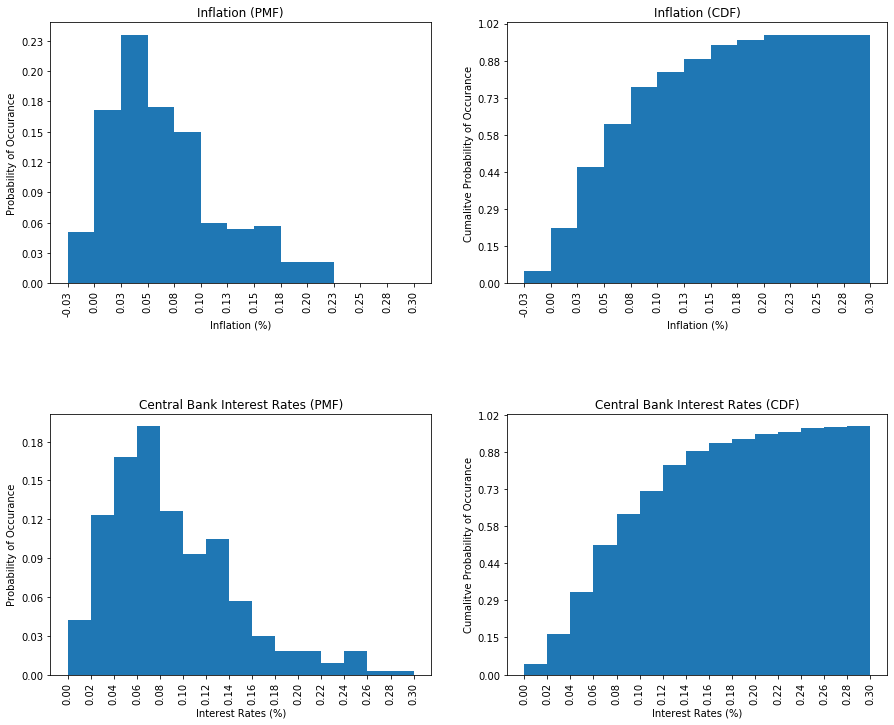

In [22]:
plt.figure(figsize=(15,12)).subplots_adjust(hspace=.5)
plt.subplot(2,2, 1)
bins = np.arange(-0.025, 0.3 + 0.025, 0.025)
labels = ["{:.2f}".format(b) for b in bins]
plt.hist(data=inflation_df, x="inflation", bins=bins);
y_ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80]
n_rows = top_gdp_df_clean.discount.shape[0]
y_labels = ["{:.2f}".format(tick/n_rows) for tick in y_ticks]
plt.xticks(ticks=bins,labels=labels, rotation=90)
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.title("Inflation (PMF)")
plt.xlabel("Inflation (%)")
plt.ylabel("Probability of Occurance");


plt.subplot(2,2, 2)
plt.hist(data=inflation_df, x="inflation", cumulative=True, bins=bins);
y_ticks = np.arange(0, n_rows + 20, 50)
y_labels = ["{:.2f}".format(tick/n_rows) for tick in y_ticks]
plt.xticks(ticks=bins,labels=labels, rotation=90)
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.title("Inflation (CDF)")
plt.xlabel("Inflation (%)")
plt.ylabel("Cumalitve Probability of Occurance");


plt.subplot(2,2,3)
bins = np.arange(0, 0.3 + 0.02, 0.02)
labels = ["{:.2f}".format(b) for b in bins]
plt.hist(data=inflation_df, x="discount", bins=bins);
y_ticks = [0, 10, 20, 30, 40, 50, 60]
n_rows = top_gdp_df_clean.discount.shape[0]
y_labels = ["{:.2f}".format(tick/n_rows) for tick in y_ticks]
plt.xticks(ticks=bins,labels=labels, rotation=90)
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.title("Central Bank Interest Rates (PMF)")
plt.xlabel("Interest Rates (%)")
plt.ylabel("Probability of Occurance");


plt.subplot(2,2,4)
plt.hist(data=inflation_df, x="discount", cumulative=True, bins=bins);
y_ticks = np.arange(0, n_rows + 20, 50)
y_labels = ["{:.2f}".format(tick/n_rows) for tick in y_ticks]
plt.xticks(ticks=bins,labels=labels, rotation=90)
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.title("Central Bank Interest Rates (CDF)")
plt.xlabel("Interest Rates (%)")
plt.ylabel("Cumalitve Probability of Occurance");

The distribution for inflation looks very similar to that of interest rates. This is unsurprising after viewing the descriptive statistics.

The most frequently occurring bucket for an inflation rate is 0.03 and 0.05. An inflation rate has about a 23% chance of being between those two values. The chances of a countries inflation rate being between -0.03 to 0.1 is roughly 75%. Between -0.03 and 0.2 is about 90%.

This clearly parallels our previous analysis of interest rates. Interest rates have the most frequent bucket occurance between 0.06 and 0.08 (about 3% more then inflation rate, consistent with the descriptive analysis). About 75% of the distribution is between 0.0 to 0.14. 90% of the distribution is between 0.0 and 0.18.

Additionally, as we look at each PMF the central bank interest rates and the inflation rate are nearly identical, but it seems the interest rates are shifted right about 2%-3%.

As we can see by the descriptive statistics and the PMF and CDF side by side, the inflation rate and interest rate very closely resemble each other.

Next the relationship between interest rates and inflation will be visualized through a scatterplot and a correlation.

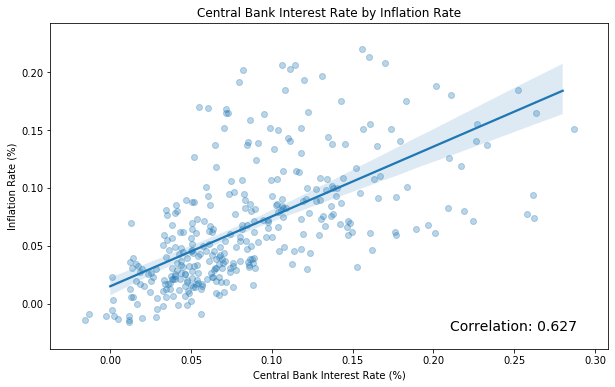

In [23]:
plt.figure(figsize=(10, 6))
plt.title("Central Bank Interest Rate by Inflation Rate")
sb.regplot(data=inflation_df, x=cols_to_examine[0], y=cols_to_examine[1],
          x_jitter=0.02,scatter_kws={'alpha': 0.3});
plt.xlabel("Central Bank Interest Rate (%)")
plt.ylabel("Inflation Rate (%)")
corr_cols = ["inflation", "discount"]
correlation = inflation_df[corr_cols].corr().iloc[0]["discount"]
correlation = "Correlation: {:.3f}".format(correlation)
plt.text(x=0.21, y=-0.023, s=correlation, fontsize=14);

The positive strong correlation is not suprising after viewing the distributions side by side. The discount rate and the inflation rate tend to mirror each other. Now that this relationship is clear a theory can be developed as to why this occurs. Remember that this is a tentative conclusion and would need further investigation to confirm.

Central banks use interest rates as a monetary tool to either stimulate the economy to expand during a recession, cool the growth of the economy to prevent bubbles, or keep rates stable to keep the economies growth on its current track. Fast rising inflation can be an indicator of a bubble, low inflation could be a signal of a current recession, and a good target level of inflation can be a signal of a healthy economy.

The central bank  tends to cut interest rates to decrease the cost of borrowing. This increases the amount of money in circulation leading to economic growth. It is known as expansionary monatary policy. The price level (inflation) would be expected to increase. This would lead someone to expect interest rates and inflation to have a negative correlation, as interest rates tend to increase inflation tends to go down on a macroeconomic level. At first glance this seems to contradict the charts above. This is actually what happens in the long term, and would better be shown by a time series chart. This chart instead shows the immediate response the central bank takes to achieve long term goals.

It is important to remember that the central bank tends to respond to the inflation rate to make monetary policy. If inflation is high, it is more likely that that year rates were raised to try to curb it. If inflation is low it makes sense that during that year interest rates were lowered at some point to try to raise it.

This correlation and the simularity of the two distributions is explained here to be due to the central bank using inflation rates as a key metrics to set rates. All else equal they tend to respond by lowering rates if the economy is weak signalled by low inflation and they try to cool the economy if inflation is increasing too fast.

#### Investment

Investment in this context means the percentage of gdp spent on the fixed assets of the economy plus net changes in the inventory level. Examples of fixed assets are plants, machinery, buildings and roads. Inventory includes stocks of goods held by firms to meet temporary or unexpected fluctuations in demand.

First the distribution of investment will be analyzed along with descriptive statistics and then the relationship between investment and central bank interest rates.

In [24]:
top_gdp_df_clean["investment"].describe()

count    342.00000
mean       0.26105
std        0.05603
min        0.15500
25%        0.22100
50%        0.24550
75%        0.29575
max        0.44200
Name: investment, dtype: float64

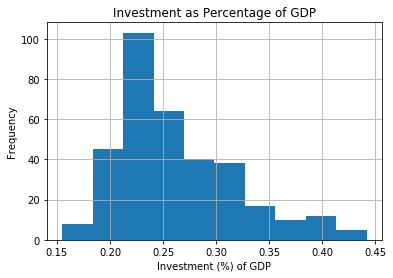

In [37]:
top_gdp_df_clean["investment"].hist()
plt.xlabel("Investment (%) of GDP")
plt.ylabel("Frequency")
plt.title("Investment as Percentage of GDP");

Investment has a slight right skew. It seems to be pretty close to a normal distribution. It also turns out that as more data points are taken investment seems to converge to a normal distribution.

In [26]:
country_list = derive_countries_by_percentile(60, 100)
investment_df = create_dataset(paths_and_labels, country_list)

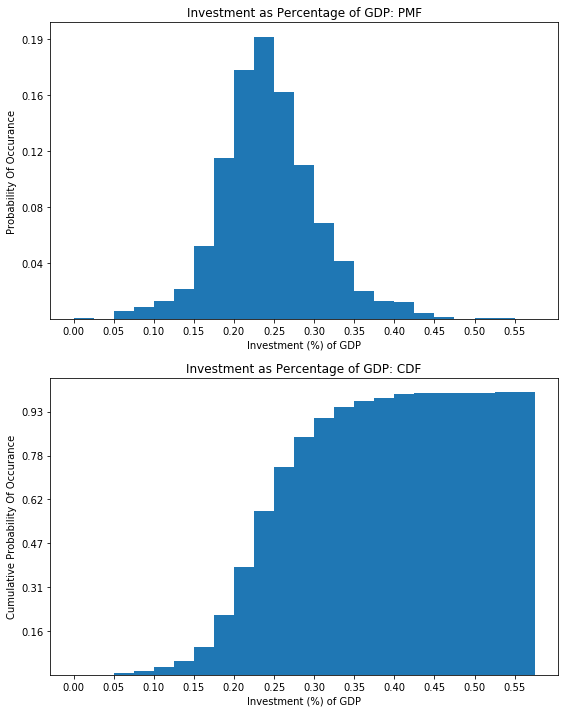

In [27]:
plt.figure(figsize=(20,12)).subplots_adjust(hspace=.2)
plt.subplot(2,2,1)
bins=np.arange(0, 0.6, 0.025)
x_ticks = [value for index, value in enumerate(bins) if index % 2 == 0]
x_labels = ["{:.2f}".format(tick) for tick in x_ticks]
y_ticks = [50, 100, 150, 200, 250]
n_rows = investment_df.investment.shape[0]
y_labels = ["{:.2f}".format(tick / n_rows) for tick in y_ticks]
plt.hist(investment_df["investment"], bins=bins);
plt.xticks(ticks=x_ticks, labels=x_labels);
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.xlabel("Investment (%) of GDP")
plt.ylabel("Probability Of Occurance")
plt.title("Investment as Percentage of GDP: PMF");


plt.subplot(2,2,3)
bins=np.arange(0, 0.6, 0.025)
x_ticks = [value for index, value in enumerate(bins) if index % 2 == 0]
x_labels = ["{:.2f}".format(tick) for tick in x_ticks]
y_ticks = [200, 400, 600, 800, 1000, 1200]
n_rows = investment_df.investment.shape[0]
y_labels = ["{:.2f}".format(tick / n_rows) for tick in y_ticks]
plt.hist(investment_df["investment"], bins=bins, cumulative=True);
plt.xticks(ticks=x_ticks, labels=x_labels);
plt.yticks(ticks=y_ticks, labels=y_labels)
plt.xlabel("Investment (%) of GDP")
plt.ylabel("Cumulative Probability Of Occurance")
plt.title("Investment as Percentage of GDP: CDF");

In [28]:
investment_df['investment'].describe()

count    1289.000000
mean        0.244055
std         0.062667
min         0.003000
25%         0.207000
50%         0.238000
75%         0.276000
max         0.580000
Name: investment, dtype: float64

The PMF and CDF of the distribution of investments seems to support the idea that they are normally distributed given more data. The PMF has the traditional bell shaped curve and the CDF is steepest at the top occurring bucket in the PMF. The mean and median are very close together as well. The mode (the most frequently occurring bucket in the PMF) also fits the mean and median. This draws us the tentative conclusion that investment tends to draw a normal distribution as more country data is gathered.

The standared deviation is 0.06, so by the assumption of the normal distribution roughly 68% of the data falls into the 0.18 to 0.29. 0.12 and 0.35 contains 95% of the data. 0.06 to 0.41 contains 99.7% 0f the data. This is reflected in the CDF as well.

This shows that the countries who spend less on investment are about equal to the countries that spend more on investment. This makes sense, as the percentage spent on investment seems independent of extreme outliers that cause high skewing. 

Because the original data is pretty similar to a normal distribution, removing outliers for the purposes of this analysis won't be necessary. The top 10th percentile of rich gdp countries will be used as before.

The relationship between central bank interest rates as an explanatory variable for the response variable investment will now be examined.

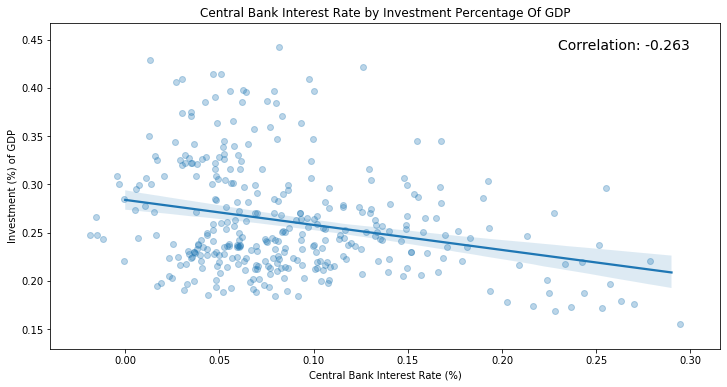

In [29]:
cols_to_examine = ["discount", "investment"]
plt.figure(figsize=(12, 6))
plt.title("Central Bank Interest Rate by Investment Percentage Of GDP")
sb.regplot(data=top_gdp_df_clean, x=cols_to_examine[0], y=cols_to_examine[1],
          x_jitter=0.02,scatter_kws={'alpha': 0.3});
plt.xlabel("Central Bank Interest Rate (%)")
plt.ylabel("Investment (%) of GDP");

correlation = top_gdp_df_clean[cols_to_examine].corr().iloc[0].investment
correlation_label = "Correlation: {:.3f}".format(correlation)
plt.text(x=0.23, y=0.44, s=correlation_label, fontsize=14);

This scatterplot shows visually how people would respond in their capital investments in the short term to a particular central bank interest rate. Central bank interest rates have a clear negative correlation with percentage of gdp spent on investment. This seems pretty intuitive. The central bank interest rate sets the cost of borrowing. If the cost of borrowing is higher people will borrow less money. At the macro level, this would lead to a lower overall percentage of the gdp being spent on capital investment.

#### Investment Inflows and Outflows

Investment inflow are foreign direct investments, which for example are activities like mergers, aquisitions, and oversees profit earnings being reinvested in the local economy. Investment outflow is the inverse. These are measured as a percentage of gdp. They can be thought of foreign capital investment.

Both inflows and outflows will be examined independently, together, in relation to investment, and finally in relation to central bank interest rates.

In [30]:
cols_to_examine = ["inflow", "outflow"]
top_gdp_df_clean[cols_to_examine].describe()

,inflow,outflow
count,342.000000,342.000000
mean,1.219661,0.803341
std,1.353049,0.925078
min,-0.099700,-0.360000
25%,0.217500,0.232000
50%,0.774000,0.502000
75%,1.765000,1.017500
max,9.200000,6.280000


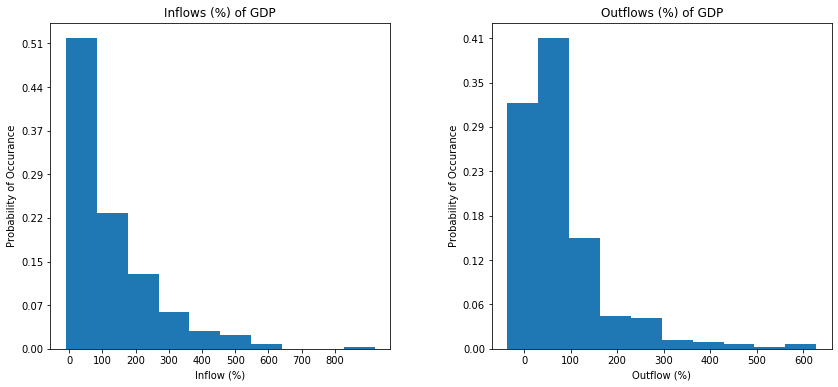

In [31]:
plt.figure(figsize=(14,6)).subplots_adjust(wspace=.3)
plt.subplot(1,2,1)
plt.title("Inflows (%) of GDP")
plt.hist(data=top_gdp_df_clean, x="inflow");
n_rows = top_gdp_df_clean.inflow.shape[0]
x_ticks = [0, 1, 2, 3,  4, 5,  6, 7, 8]
x_labels = [str(tick * 100) for tick in x_ticks]
y_ticks = [0, 25, 50, 75, 100, 125, 150,175]
y_labels = ["{:.2f}".format(tick / n_rows) for tick in y_ticks]
plt.xticks(ticks=x_ticks, labels = x_labels)
plt.yticks(ticks=y_ticks, labels = y_labels)
plt.xlabel("Inflow (%)")
plt.ylabel("Probability of Occurance")

plt.subplot(1,2,2)
plt.title("Outflows (%) of GDP")
plt.hist(data=top_gdp_df_clean, x="outflow");
x_ticks = [0, 1, 2, 3,  4, 5,  6]
x_labels = [str(tick * 100) for tick in x_ticks]
y_ticks = [0, 20, 40, 60, 80, 100, 120, 140]
y_labels = ["{:.2f}".format(tick / n_rows) for tick in y_ticks]
plt.xticks(ticks=x_ticks, labels = x_labels)
plt.yticks(ticks=y_ticks, labels = y_labels);
plt.xlabel("Outflow (%)")
plt.ylabel("Probability of Occurance");

A very similar distribution for inflows and outflows exist. It makes sense that the distributions are very similar. This could be true for the same reason that investment overall is normally distributed. A normal distribution implies a similar amount of countries invest above and below the mean. That is there are a similar amount of low and high investment countries.  It could follow a similar amount of countries have very high inflows and an equal number of countries would have very high outflows. 

Another more intuitive explanation this could be occurring is that for every country that has investment inflow another country has equal outflow.

It also makes sense that a large portion of the distribution is above 100% making up the right skew. Emerging countries with small gdps but high growth potential could have very high inflows, well above the gdp. Investors would contribute to the high grow potential by investing in capital far in excess of the gdp for a given year. An emerging country that was previously seen as having high growth prospects that investors grow skeptical of could have high capital flight. That is bullish investors could pull investment far in excess of their small gdp.

Because of the intuitive explanation for the right skew, only one outlier will be addressed: The country with inflow in excess of 800. That will make the two distributions more similar and not throw off side by side comparisons.

In [32]:
inflow_outflow_df = top_gdp_df_clean.copy()
inflow_outflow_df = inflow_outflow_df.query("inflow < 8")

In [33]:
inflow_outflow_df[cols_to_examine].describe()

,inflow,outflow
count,341.000000,341.000000
mean,1.196259,0.787280
std,1.283848,0.877389
min,-0.099700,-0.360000
25%,0.217000,0.232000
50%,0.772000,0.500000
75%,1.750000,1.010000
max,6.230000,5.750000


Below is the relationship of inflows and outflows to each other. This shows us that inflows are positively correlated with outflows, perhaps countries that have a tendency to have lots of money flowing in tend to have a lot of money flowing out. This pains a picture of countries agenda's are to keep a balanced budget and not to hold their inflow/ outflows below 100%.

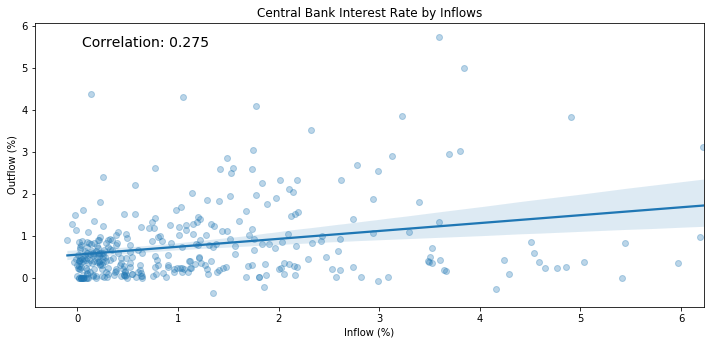

In [34]:
cols_to_examine = ["inflow", "outflow"]
plt.figure(figsize=(12, 12)).subplots_adjust(hspace=.3)
plt.subplot(2,1,1)
plt.title("Central Bank Interest Rate by Inflows")
sb.regplot(data=inflow_outflow_df, x=cols_to_examine[0], y=cols_to_examine[1],
          x_jitter=0.02,scatter_kws={'alpha': 0.3});
plt.xlabel("Inflow (%)")
plt.ylabel("Outflow (%)");
# x_ticks = np.arange(0.15, 0.45 + 0.05, 0.05)
# x_labels = ["{:.2f}".format(tick) for tick in x_ticks]
y_ticks = [0, 1, 2, 3,  4, 5,  6]
y_labels = [str(tick * 100) for tick in y_ticks]
# plt.xticks(ticks=x_ticks, labels=x_labels);
# plt.yticks(ticks=y_ticks, labels=y_labels);
correlation = inflow_outflow_df[cols_to_examine].corr().iloc[0].outflow
correlation_label = "Correlation: {:.3f}".format(correlation)
plt.text(x=0.05, y=5.5, s=correlation_label, fontsize=14);

To view the relationship between inflow, outflow, and investment two scatterplots will be drawn. Investment will replace central bank interest rates as the explanatory variable.

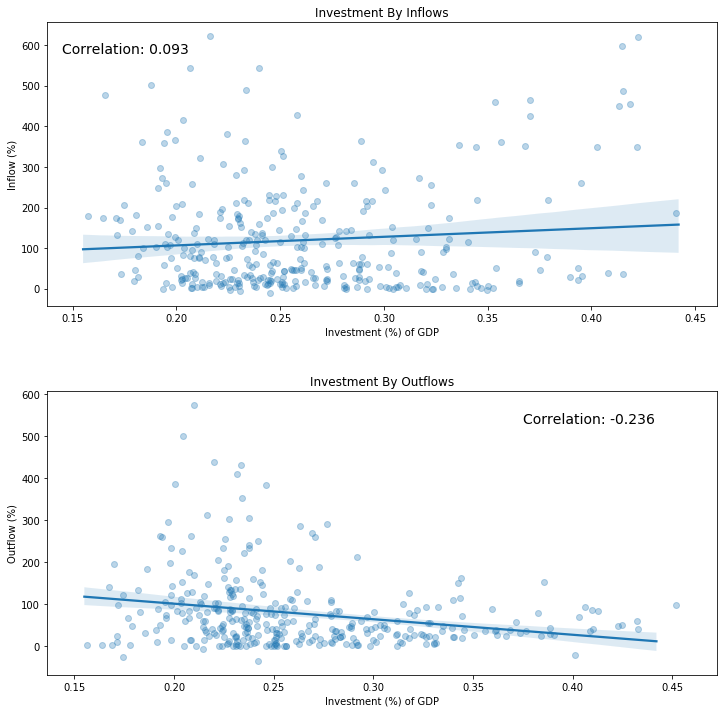

In [35]:
cols_to_examine = ["investment", "inflow"]
plt.figure(figsize=(12, 12)).subplots_adjust(hspace=.3)
plt.subplot(2,1,1)
plt.title("Investment By Inflows")
sb.regplot(data=inflow_outflow_df, x=cols_to_examine[0], y=cols_to_examine[1],
          x_jitter=0.02,scatter_kws={'alpha': 0.3});
plt.xlabel("Investment (%) of GDP")
plt.ylabel("Inflow (%)");
x_ticks = np.arange(0.15, 0.45 + 0.05, 0.05)
x_labels = ["{:.2f}".format(tick) for tick in x_ticks]
y_ticks = [0, 1, 2, 3,  4, 5,  6]
y_labels = [str(tick * 100) for tick in y_ticks]
plt.xticks(ticks=x_ticks, labels=x_labels);
plt.yticks(ticks=y_ticks, labels=y_labels);
correlation = inflow_outflow_df[cols_to_examine].corr().iloc[0].inflow
correlation_label = "Correlation: {:.3f}".format(correlation)
plt.text(x=0.145, y=5.8, s=correlation_label, fontsize=14);

cols_to_examine = ["investment", "outflow"]
plt.subplot(2,1,2)
plt.title("Investment By Outflows")
sb.regplot(data=inflow_outflow_df, x=cols_to_examine[0], y=cols_to_examine[1],
          x_jitter=0.02,scatter_kws={'alpha': 0.3});
plt.xlabel("Investment (%) of GDP")
plt.ylabel("Outflow (%)");
y_ticks = [0, 1, 2, 3,  4, 5,  6]
y_labels = [str(tick * 100) for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels);
correlation = inflow_outflow_df[cols_to_examine].corr().iloc[0].outflow
correlation_label = "Correlation: {:.3f}".format(correlation)
plt.text(x=0.375, y=5.3, s=correlation_label, fontsize=14);

Interestingly inflows are positively correlated with investment and outflows are negatively correlated with investment. It could be because all else equal, when a country de-invests or invests in itself, investors tend to follow. Perhaps investors use government spending as a metric to invest or deinvest in a foreign economy. 

Comparing the magnitudes of the correlations are limited in their usefulness without rigorous hypothesis testing and are therefore above the scope of this analysis.

Lastly inflows and outflows will be examined in relation to central bank interest rates and to each other.

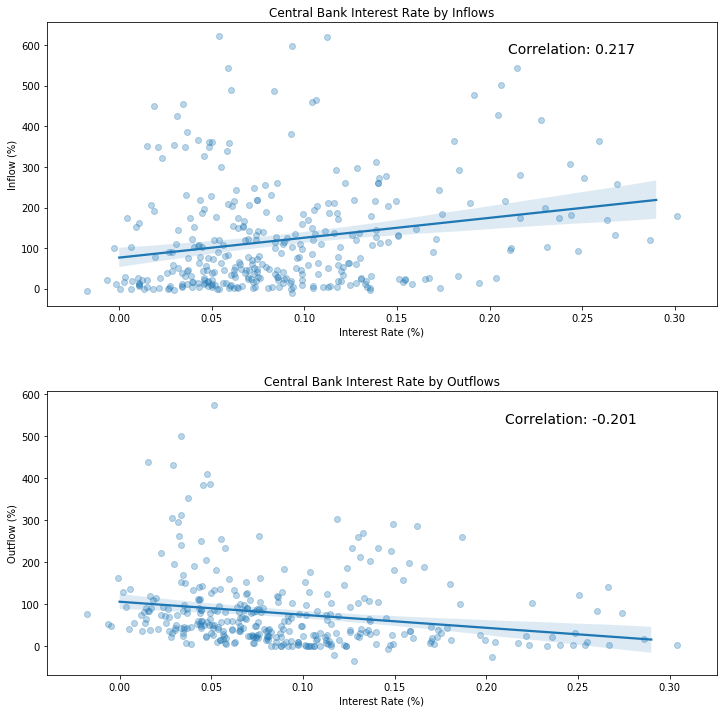

In [36]:
cols_to_examine = ["discount", "inflow"]
plt.figure(figsize=(12, 12)).subplots_adjust(hspace=.3)
plt.subplot(2,1,1)
plt.title("Central Bank Interest Rate by Inflows")
sb.regplot(data=inflow_outflow_df, x=cols_to_examine[0], y=cols_to_examine[1],
          x_jitter=0.02,scatter_kws={'alpha': 0.3});
plt.xlabel("Interest Rate (%)")
plt.ylabel("Inflow (%)");
y_ticks = [0, 1, 2, 3,  4, 5,  6]
y_labels = [str(tick * 100) for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels);
correlation = inflow_outflow_df[cols_to_examine].corr().iloc[0].inflow
correlation_label = "Correlation: {:.3f}".format(correlation)
plt.text(x=0.21, y=5.8, s=correlation_label, fontsize=14);

cols_to_examine = ["discount", "outflow"]
plt.subplot(2,1,2)
plt.title("Central Bank Interest Rate by Outflows")
sb.regplot(data=inflow_outflow_df, x=cols_to_examine[0], y=cols_to_examine[1],
          x_jitter=0.02,scatter_kws={'alpha': 0.3});
plt.xlabel("Interest Rate (%)")
plt.ylabel("Outflow (%)");
y_ticks = [0, 1, 2, 3,  4, 5,  6]
y_labels = [str(tick * 100) for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels);
correlation = inflow_outflow_df[cols_to_examine].corr().iloc[0].outflow
correlation_label = "Correlation: {:.3f}".format(correlation)
plt.text(x=0.21, y=5.3, s=correlation_label, fontsize=14);

Inflows have a positive correlation to interest rates. This could be because assets represent better money making opportunities than currency as interest rates increase. Outflows could be for the inverse reason.

Lastly notice that investment and inflows/outflows have a similar relationship to central bank interest rates and inflows/outflows. Perhaps this is because inflows represent money making opportunities where outflows represent deinvestment as the best option. As interest rates go up, there is more money to be made in investing in assets. As investment goes up, further growth could be seen as a signal for even more growth. Outflows are the reverse of inflows so a negative relationship exists.



<a id='conclusions'></a>
## Conclusions

### Results

The key metric investigated was central bank interest rates over the top 10th percentile of GDP rich  countries. This was chosen as an explanatory variable because central bank interest rates are a key decision made in macroeconomic policy making while the other metrics are a consequence. The other metrics examined were investment, inflows, outflows, and inflation.

Discount rates followed a right skewed distribution with 90% falling between 0.00 and 0.14.  A right skew could be because low interest rates signal expansionary policy and economic growth is a key agenda for central banks. 

The distributions of inflation and discount rates tended to follow each other closely. Discount rates typically were about 0.03 percentage points ahead. They also had a strong positive correlation of 0.627. This could be because monetary decision makers use inflation as a key factor in making policy. So if inflation is high that year, it make sense rates were raised to curb it that same year.

Investment seemed to follow a normal distribution as more data points were added in. This shows that the percentage of countries that invest a lot are similar in number to countries that invest a little. Central bank rates have a correlation of -0.263 with investment. This could be because as rates increase the cost of investment is higher which leads to less of it.

Inflows and outflows were investigated alone, together, compared with investment and compared with discount rates.

They tend to follow a similar distribution to each other with a heavy right skew. The bulk of data falls into 0-100% of the total gdp made up of inflow or outflows. But about 50% of the countries had inflow/outflow in excess of 100%, the top being 600% of gdp. This makes sense because all else equal to the world economy inflow should equal outflow. Inflows and outflows  also have a positive correlation with each other. This could be because countries tend to like to have balanced budgets if they are healthy. This paints a picture of countries agenda to have a balanced budget and not keeping inflows/ outflows below a certaain amount.

Investment and central bank interest rates were both positively correlated with inflow and negatively with outflow. This could be because inflows represent a money making opportunity, which leads to investing in capital (investment) or in assets (making money on higher interest rates).

### Limitations

At this point in time all analysis is descriptive in nature. Rigorous hypothesis testing should be used to lower the probability that these relationships are due to chance before generalizing these relationships.

Also all relationships are correlations and are only describing the data. Causation should not be implied from this investigation. In other words, central bank interest rates may not be causing the relationship to any of the metrics under investigation.

Other then addressing the limitations to this analysis, it can be investigated further in a few ways:

Data modeling can be used to formalize the relationships between macroeconomic variables and bring rigor to predictictions. 

Examining the relationships across percentiles to see if the relationships differ or if they hold statistical rigor to the top 10th percentile could also add predictive power to this analysis. 

New metrics could also be gathered and analyzed as response variables. If countries are used as the primary key a left join can be performed, adding more data to countries of interest. 

Lastly, yearly data is available but not used in this analysis. Therefore time series analysis can be performed to see how central bank interest rates or other metrics have varied over time.